# **Data Cleaning Notebook**

## Objectives

*   Evaluate missing data
*   Clean data

## Inputs

* outputs/datasets/collection/house_prices_records.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

  * Cleaned Data Pipeline

---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

---

## Load Collected Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
    )
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration

We will check the distribution and shape from a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and Predictive Power Score Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display at Heatmaps



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



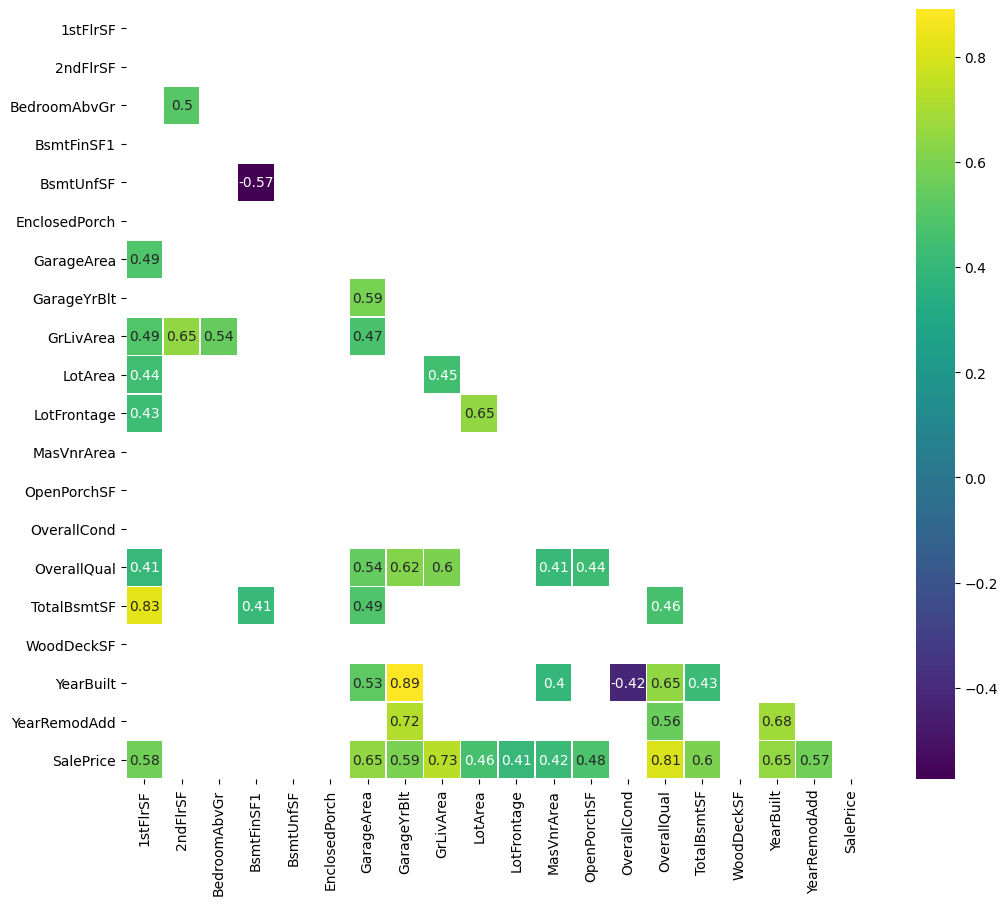



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



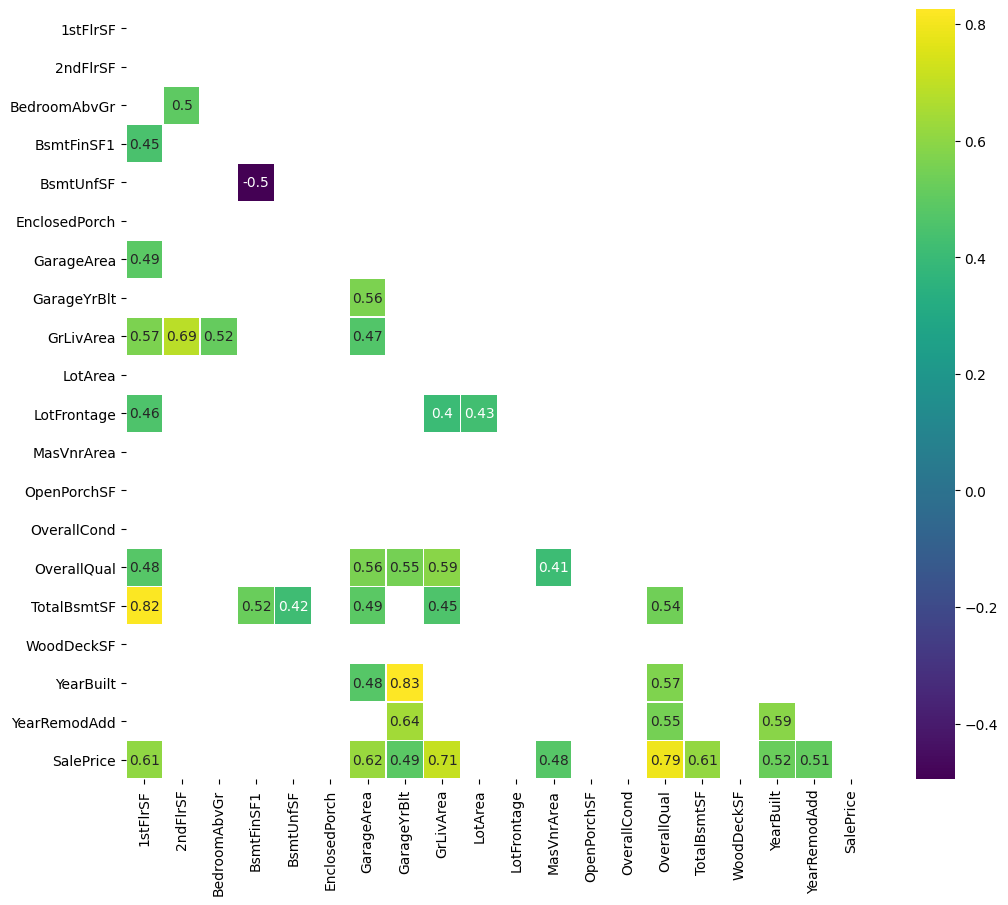



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



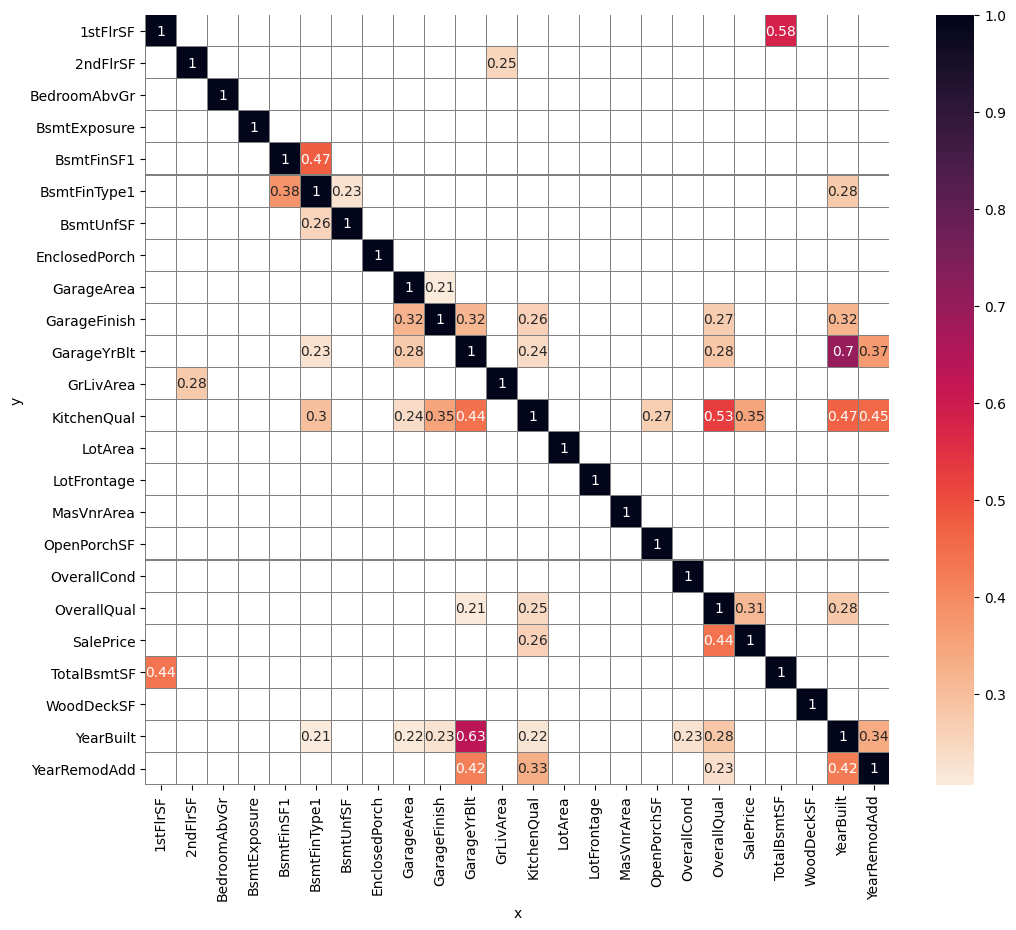

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

---

## Data Cleaning
#### Assessing Missing Data Levels
Custom function to display missing data levels in a dataframe, it shows the aboslute levels, relative levels and data type

In [10]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

Check missing data levels for collected dataset

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


### Data Cleaning Spreadsheet Summary

Firt we will look at the missing data for `GarageFinish` and `GarageYrBlt` along with the house's `YearBuilt` and `GarageArea`. Then we will compare the `BasementFinish` and `GarageFinish` where the area of the feature is 0 and missing.

In [12]:
df_grg_nan = df[df['GarageFinish'].isna()]
df_grg_nan[['GarageFinish', 'GarageYrBlt', 'GarageArea', 'YearBuilt']]

,GarageFinish,GarageYrBlt,GarageArea,YearBuilt
7,NaN,1973.0,484,1973
12,NaN,1962.0,352,1962
23,NaN,1976.0,572,1976
27,NaN,2008.0,772,2007
35,NaN,2004.0,691,2004
...,...,...,...,...
1401,NaN,2004.0,398,2004
1415,NaN,2007.0,660,2007
1438,NaN,1957.0,923,1957
1442,NaN,2008.0,812,2008


In [13]:
df_grgyear_nan = df[df['GarageYrBlt'].isna()]
df_grgyear_nan[['GarageFinish', 'GarageYrBlt', 'GarageArea']]

,GarageFinish,GarageYrBlt,GarageArea
39,None,NaN,0
48,None,NaN,0
78,None,NaN,0
88,None,NaN,0
89,None,NaN,0
...,...,...,...
1349,None,NaN,0
1407,None,NaN,0
1449,None,NaN,0
1450,None,NaN,0


In [14]:
df_checkbsm = df.loc[(df['BsmtFinType1'].isna()) & (df['TotalBsmtSF'] == 0)]
df_checkbsm[['BsmtFinType1', 'TotalBsmtSF']]

,BsmtFinType1,TotalBsmtSF
90,NaN,0
182,NaN,0
362,NaN,0
736,NaN,0
1049,NaN,0
1179,NaN,0


In [15]:
df_checkgarages = df.loc[(df['GarageFinish'].isna()) & (df['GarageArea'] == 0)]
df_checkgarages[['GarageFinish', 'GarageArea']]

,GarageFinish,GarageArea
125,NaN,0
431,NaN,0
528,NaN,0
649,NaN,0
710,NaN,0
1173,NaN,0
1323,NaN,0
1325,NaN,0


We will now identify potential approaches for handling missing data since the ML models need a dataset that has no missing data. The changes to be made for each variable and their missing data are presented below:

#### `CategoricalVariableImputer`

`GarageFinish` showed little to no correlation against the sale price in our Sale Price Study Notebook study, and there is no clarity on its indicator. Thus, we'll fill the missing data with `Unf`. 

According to the PPS, there is a moderate correlation between `GarageFinish`, `Overall Quality`, `YearBuilt` and other variables. We could predict what `GarageFinish` could be based on different variables to improve our model. We will use the CategoricalVariableImputer function in our case as using the frequent category as our imputation method is easy to implement, a fast way of obtaining complete datasets and can be integrated into production (during model deployment). 

Also,` we will follow the same strategy with the BsmtFinType1`; we will fill in `Unf` for any missing data. Checking the missing values above, all have a `TotalBsmtSF`, and we don't need to fill in any of the missing values with `None`.

#### `ArbitraryNumberImputer`
The ArbitraryNumberImputer function will replace the missing data of `2ndFlrSF`, `EnclosedPorch`, `MasVnrArea` and `WoodDeckSF` with 0 as it is the most common value for all of these variables. Looking at`EnclosedPorch`, the missing data is 90.7%, and 7.9% of the data available is 0. Thus, more than 80% of the available data is 0. Hence, we use the ArbitraryNumerImputer to impute the mode value for each of these columns. 

It is common to see columns with more than 80% of missing data to be dropped. Yet, in our case, the house size is one of the most significant predictors of Sale Price, and we want to investigate the PPS, namely if we'll get a better PPS by combining all the variables related to the house size once our data is cleaned. 


#### `MeanMedianImputer`
We will use MeanMedianImputer for `LotFrontage` another variable related to the house, to attribute the NaN values with a median value. Using the Pandas Profile Report, we chose to use the MeanMedianImputer function due to the normal distribution we saw on our Sale Price Study Notebook. 

We will also use MeanMedianImputer for `BedroomAbvGr`. It is noteworthy that we do not have a great picture of the above grade. We could investigate further and estimate the grade by looking at the houses, their overall size and overall quality. In our case, we will go with the MeanMedianImputer.

Last,  NaN values appear where a house doesn't have a garage in the `GarageYrBlt`. Thus, we will add the MeanMedianImputer to this variable.

![DataCleaningSpreadsheet](../media/DataCleaning.png)

### Custom functions for Data Cleaning

We will use the following custom function from [Code Institute](https://codeinstitute.net/se/). This function will help visualise our changes' effect on the data by using imputation methods from the feature engine and then plotting the original and cleaned datasets against each other.

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
  # first on variables that you applied the method
  # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

Next we willset up the parameters for the cleaning functions by following these steps:

1 - Select an imputation method

2 - Select variables to apply the method to

3 - Create a separate DataFrame to apply the method

4 - Assess the effect on the variable distribution

We will start with `CategoricalVariableImputer` for:
* `GarageFinish` 
* `BsmtFinType1`


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




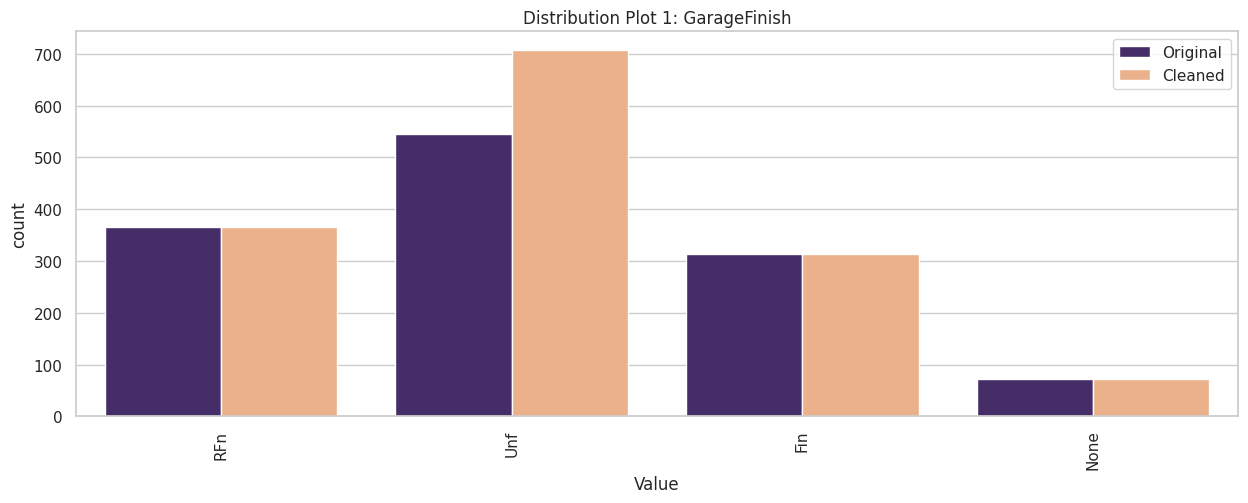

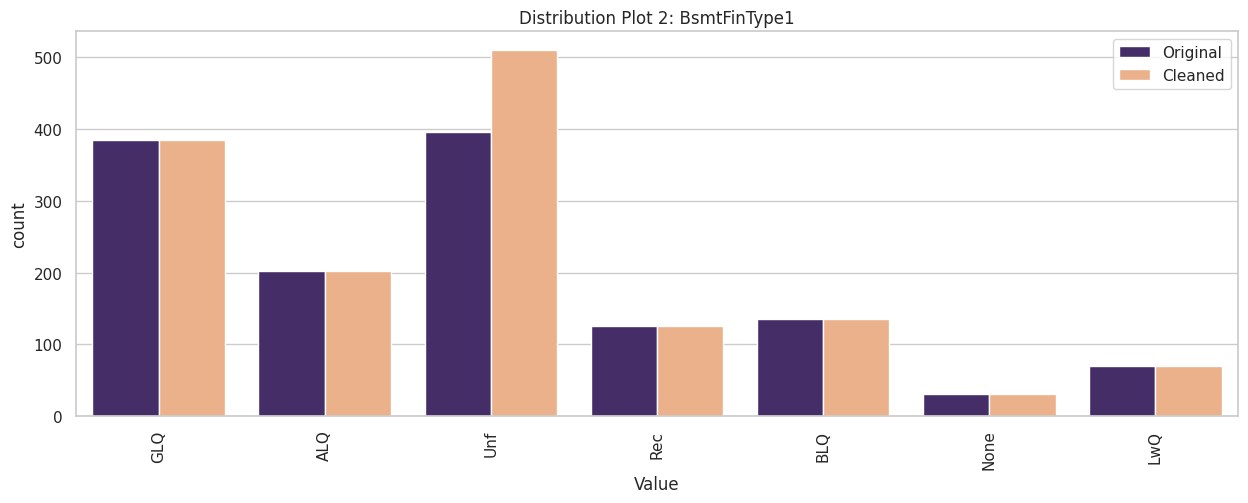

In [17]:
# Select an imputation method
from feature_engine.imputation import CategoricalImputer

# Select variables to apply the method to
variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

# Create a separate DataFrame to apply the method
imputer = CategoricalImputer(imputation_method='missing',fill_value='Unf',
                             variables=variables_method)

# Create a separate DataFrame to apply the method
df_method = imputer.fit_transform(df)

# Assess the effect on the variable distribution
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

Next `ArbitraryNumberImputer` for:
* `2ndFlrSF`
* `EnclosedPorch`
* `MasVnrArea`
* `WoodDeckSF`


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'] 




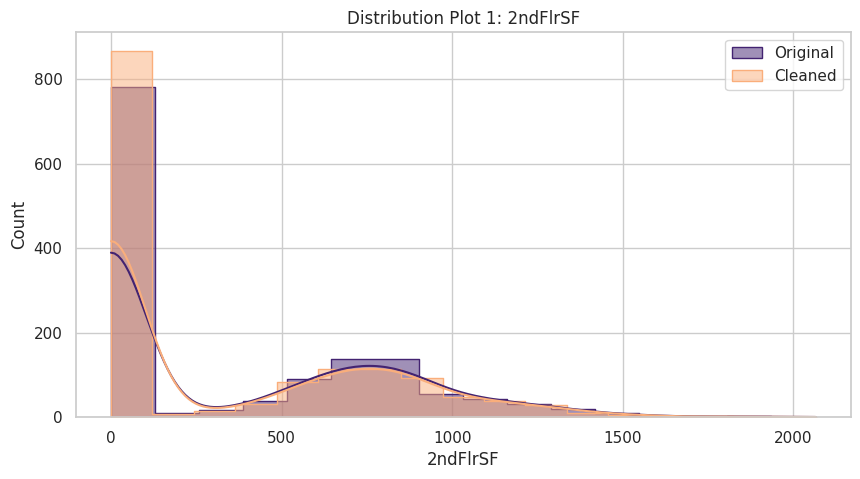

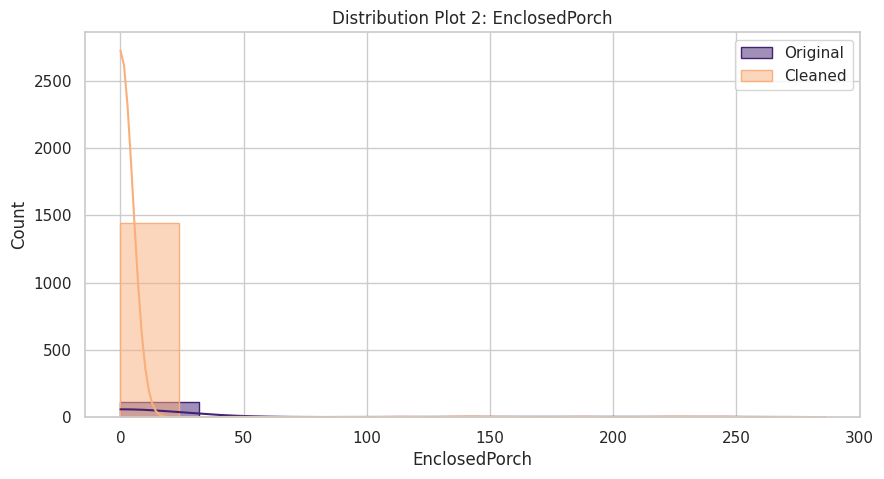

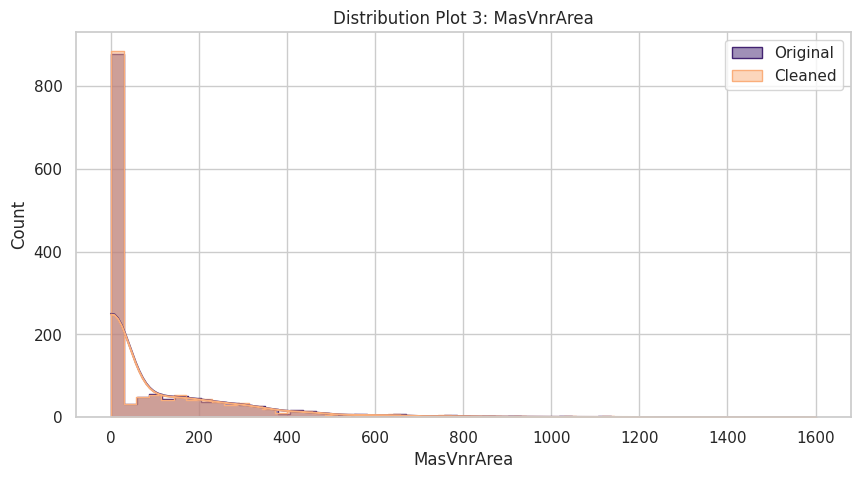

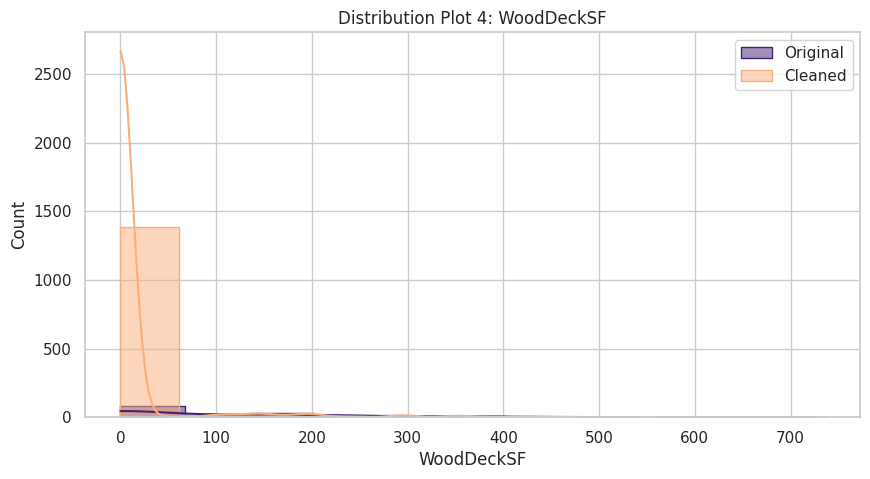

In [18]:
# Select an imputation method
from feature_engine.imputation import ArbitraryNumberImputer

# Select variables to apply the method to
variables_method = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']
variables_method

# Create a separate DataFrame to apply the method
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)

# Create a separate DataFrame to apply the method
df_method = imputer.fit_transform(df)

# Assess the effect on the variable distribution
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

And `MeanMedianImputer` for:
* `LotFrontage`
* `BedroomAbvGr`
* `GarageYrBlt`


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




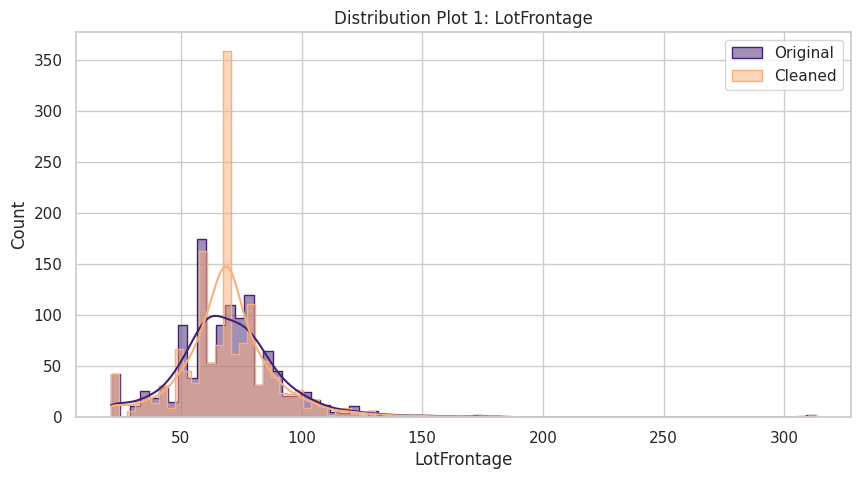

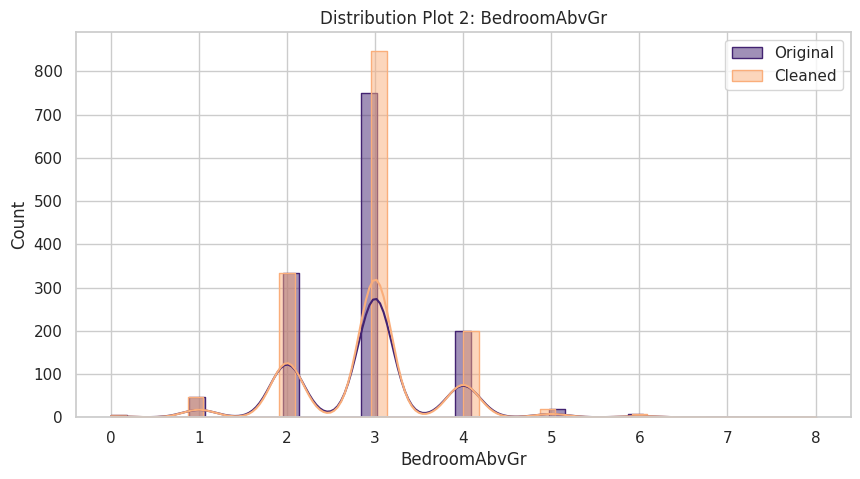

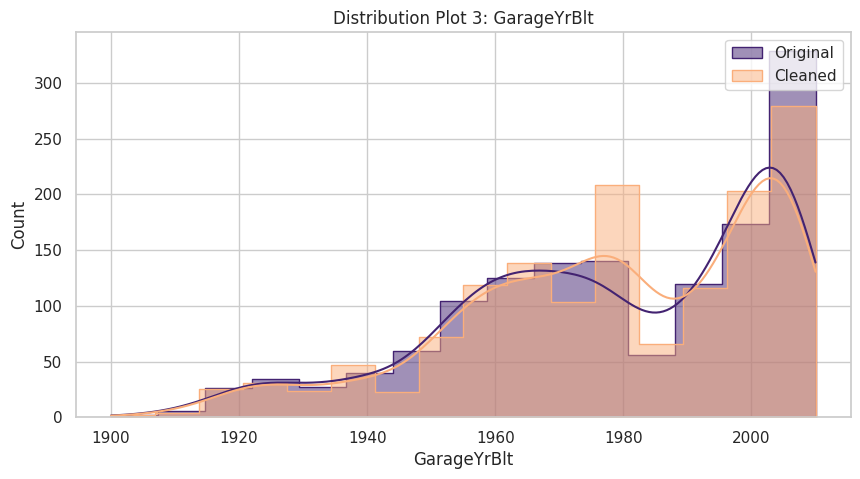

In [19]:
# Select an imputation method
from feature_engine.imputation import MeanMedianImputer

# Select variables to apply the method to
variables_method = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
variables_method

# Create a separate DataFrame to apply the method
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)

# Create a separate DataFrame to apply the method
df_method = imputer.fit_transform(df)

# Assess the effect on the variable distribution
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

---

## Split Train and Test Set

In [20]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


---

## Apply the Changes to the Missing Data

`CategoricalImputer`

In [21]:
variables_method = ['GarageFinish', 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing',fill_value='Unf',
                             variables=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

`ArbitraryNumberImputer`

In [22]:
variables_method = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

`MeanMedianImputer`

In [23]:
variables_method = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

#### Checking if there is any missing data

In [24]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


No missing data. Which means that there are no other missing variables we need to deal with and we can now push our files to the repo.

---

# Push files to Repo

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)


### Train Set

In [ ]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [ ]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

Next we will work on the Feauture Engineering Notebook.